## Pendulum Simulation for Multiple Non-Linear Regression Problem Generation

### Dr. Andrew Strelzoff, Dr. James Ross ERDC-ITL-Data Science

#### MIT License

Based on the terrific article by Jake VanderPlas here https://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/

In [7]:
#plot charts in the notebook
%matplotlib inline

#load some useful libraries
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.fftpack import fft

from IPython.display import HTML, display_html

import random

In [3]:
#load several SKLearn libraries useful for multiple regression
from sklearn.linear_model import LinearRegression, Ridge,MultiTaskLasso,MultiTaskElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import RadiusNeighborsRegressor,KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor,RegressorChain
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [4]:
#multi-section pendulum simulation
def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(forces, particles)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

In [9]:
#post processing function for pendulum simulation data
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

def animate_pendulum(x,y,t,lengths):  
    fig, ax = plt.subplots(figsize=(3,5),facecolor='red')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    limit=lengths.sum()
    ax.set(xlim=(-limit, limit), ylim=(-limit-1, limit))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

## Simulate a Double Pendumum, Gather and Plot Positional Data

### Try changing various parameters and re-running - it's fun!

In [23]:
pendulum_type = 2

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

#linear-ish "mustache"
start=40
initial_positions=[start,start] # starting angle of each section of pendulum
masses=[3.0,2.0] #mass of each point mass at the end of it's section
lengths=np.asarray([1,3])  #length of each section

#definitely non-linear
#initial_positions=[50,150] # starting angle of each section of pendulum
#masses=[1.5,1.0] #mass of each point mass at the end of it's section
#lengths=[0.5,2]  #length of each section

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)
p = integrate_pendulum(n=pendulum_type, times=t,initial_positions=initial_positions,masses=masses,lengths=lengths)
x_pend, y_pend = get_xy_coords(p,lengths)

anim = animate_pendulum(x_pend,y_pend,t,lengths)

HTML(anim.to_jshtml())


D:\anaconda\envs\modelHPC\lib\site-packages\sympy\physics\mechanics\kane.py:536: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


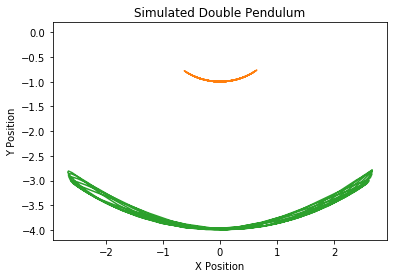

In [24]:
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Simulated Double Pendulum');
display_html(plt.plot(x_pend, y_pend))

## Real World Systems (other then mo-cap) don't report their positions

### Derive the fundmental vibrational frequences of the simulated double pendulum

<b>NOTE:</b> not a signal processing expert, please don't rip me too much, just trying to set up a more interesting toy problem that shows high-dimension multiple-regression and can easily be tuned to create either easy linear problems or ridiculously hard non-linear problems.

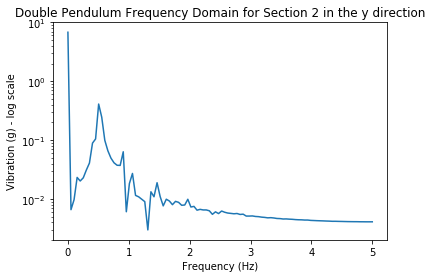

In [25]:
def estimate_frequencies(x_pos,y_pos,section,x_or_y,sampling_rate,bins):
    if x_or_y == 'x':
        direction = 0
    else:
        direction = 1
    
    # Nyquist Sampling Criteria
    T = 1/sampling_rate # inverse of the sampling rate
    frequencies = np.linspace(0.0, 1.0/(2.0*T), int(bins/2))

    # FFT algorithm
    yr = fft(y_pend[direction:bins,section]) # "raw" FFT with both + and - frequencies
    magnitudes = 2/bins * np.abs(yr[0:np.int(bins/2)]) # positive freqs only
    
    return frequencies,magnitudes
direction = 'y'
frequencies,magnitudes = estimate_frequencies(x_pend,y_pend,section=2,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)
# Plotting the results
plt.plot(frequencies, magnitudes)
#direction = 'x'
#frequencies,magnitudes = estimate_frequencies(x_pend,y_pend,section=2,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)
# Plotting the results
#plt.plot(frequencies, magnitudes)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g) - log scale')
plt.yscale('log')
plt.title('Double Pendulum Frequency Domain for Section '+str(section) + ' in the '+direction+' direction');

## Create a Double Pendulum Dataset for Machine Learning

### Let's start with an easier (mostly linear) problem and keep starting positions fixed at  (40,40) 

X will be the resulting fundemental frequencies from Double Pendulum section 1 and 2 (x direction only)

Y will be varying masses from (0.5,1.5) and lengths from (0.5,1.5) 

Can we predict <b> Y (the mass and length of each pendulum section) </b>from <b> X (the fundamental frequencies of each section of the double pendulum)? </b>


In [637]:
num =1000

dataset1_X = np.empty(shape=(num,200)) #frequencies for sections 1 (0,99) and sections 2 (100,199)
dataset1_Y = np.empty(shape=(num,4)) #weight1,weight2,length1,length2

In [639]:
#this is a bit slow - If you have a crummy computer skip this cell and load dataset1_Y.csv and dataset1_X.csv below instead 

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)

#linear-ish "mustache"
initial_positions=[40,40] # starting angle of each section of pendulum
#masses=[5,2.5] we're going to vary this
#lengths=[1,10] we're going to vary this

for i in range(0,num):
    dataset1_Y[i] = np.random.uniform(low=0.5,high=1.5,size=4)
    p = integrate_pendulum(n=2, times=t,initial_positions=initial_positions,masses=dataset1_Y[i,0:2],lengths=dataset1_Y[i,2:4])
    x_pos, y_pos = get_xy_coords(p)
    yr1 = fft(y_pos[0:bins,1]) # "raw" FFT with both + and - frequencies
    dataset1_X[i][0:100] = 2/bins * np.abs(yr1[0:np.int(bins/2)]) # positive freqs only
    yr2 = fft(y_pos[0:bins,2]) # "raw" FFT with both + and - frequencies
    dataset1_X[i][100:200] = 2/bins * np.abs(yr2[0:np.int(bins/2)]) # positive freqs only
        

In [41]:
#save dataset for anyone who doesn't want to regen data or has a potato computer and can't
#np.savetxt("dataset1_X.csv",dataset3_X,delimiter=',')
#np.savetxt("dataset1_Y.csv",dataset3_Y,delimiter=',')

In [30]:
#load saved dataset rather than generating your own
dataset1_X = np.loadtxt("dataset1_X.csv",delimiter=',')
dataset1_Y = np.loadtxt("dataset1_Y.csv",delimiter=',')
print("generated X frequency bins with shape =",dataset1_X.shape)
print("generated Y (w1,w2,l1,l2) with shape =",dataset1_Y.shape)

generated X frequency bins with shape = (1000, 200)
generated Y (w1,w2,l1,l2) with shape = (1000, 4)


In [31]:
#SPLIT DATA into Train and Test (90-10)

X_train, X_test, Y_train, Y_test = train_test_split(dataset1_X, dataset1_Y, test_size=0.10, random_state=42)

In [32]:
#ALWAYS scale your data in multiple regression problems

x_scaler_nl = StandardScaler()
X_train_scaled_nl = x_scaler_nl.fit_transform(X_train)
X_test_scaled_nl = x_scaler_nl.transform(X_test)

y_scaler_nl = StandardScaler()
Y_train_scaled_nl = y_scaler_nl.fit_transform(Y_train)
Y_test_scaled_nl = y_scaler_nl.transform(Y_test)

In [33]:
names = ["LinearRegression", "KNeighborsRegressor",  
         "DecisionTreeRegressor", "MultiTaskLasso", "MultiTaskElasticNet", 
         "Ridge", "MLPRegressor", "MultiOutputRegressor(SVR())","MultiOutputRegressor(XGBRegressor())"]

regressors = [
    LinearRegression(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    MultiTaskLasso(alpha=0.1),
    MultiTaskElasticNet(alpha=0.1),
    Ridge(alpha=0.5),
    MLPRegressor(hidden_layer_sizes=(100,400,100,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=2000,
                                       learning_rate_init=0.01,
                                       alpha=0.1),
    MultiOutputRegressor(SVR(kernel='rbf', C=10.0)), #kernel = ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
    MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7))]


In [34]:
mse = {} 
for name, clf in zip(names, regressors):
        print("training ",name)
        clf.fit(X_train_scaled_nl, Y_train_scaled_nl)
        mse[name] = mean_squared_error(Y_test_scaled_nl, clf.predict(X_test_scaled_nl))
        

training  LinearRegression
training  KNeighborsRegressor
training  DecisionTreeRegressor
training  MultiTaskLasso
training  MultiTaskElasticNet
training  Ridge
training  MLPRegressor
training  MultiOutputRegressor(SVR())
training  MultiOutputRegressor(XGBRegressor())


In [35]:
sorted(mse.items(), key=lambda kv: kv[1])

[('MultiOutputRegressor(XGBRegressor())', 0.31771210885704293),
 ('MultiTaskElasticNet', 0.35817080149161035),
 ('MultiTaskLasso', 0.37057491666326003),
 ('MultiOutputRegressor(SVR())', 0.44119105572492767),
 ('Ridge', 0.4785470585302728),
 ('MLPRegressor', 0.5006695387463962),
 ('KNeighborsRegressor', 0.5212025166875521),
 ('LinearRegression', 0.5919176521569255),
 ('DecisionTreeRegressor', 0.7497327051155085)]

In [40]:
#MAKE PREDICTIONS!
best_model = regressors[names.index('MultiOutputRegressor(XGBRegressor())')]
Y_test_pred_scaled = best_model.predict(X_test_scaled_nl)

In [41]:
###VERY IMPORTANT - we have to de-scale to compare with the original data

Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)

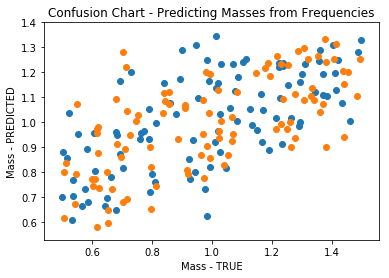

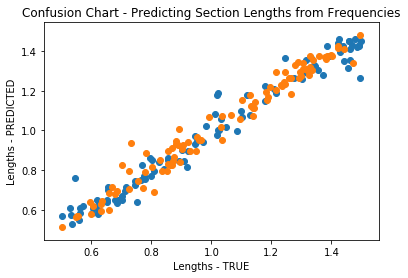

In [45]:
#Plot results TRUE vs PREDICTED - best would be a straight diagonal line at TRUE=PREDICTED
plt.scatter(Y_test[:,0], Y_test_pred_unscaled[:,0])
plt.xlabel('Mass - TRUE')
plt.ylabel('Mass - PREDICTED')

plt.title('Confusion Chart - Predicting Masses from Frequencies');

plt.scatter(Y_test[:,1], Y_test_pred_unscaled[:,1])
plt.show()

plt.xlabel('Lengths - TRUE')
plt.ylabel('Lengths - PREDICTED')
plt.title('Confusion Chart - Predicting Section Lengths from Frequencies');
plt.scatter(Y_test[:,2], Y_test_pred_unscaled[:,2])
plt.scatter(Y_test[:,3], Y_test_pred_unscaled[:,3])

## We seem to be very good at predicting length, but not mass, why?

### go back up simulation and plotting cell above and tinker with the pendulum inputs and re-run

### can you figure it out?

In [ ]:
#left empty












### DISCUSSION

Try entering 5 and 1 for the masses.  Now try 10 and 2 .  Same answer right?

<b>This means the individual masses of the section can't be determined by the simulation results.</b>

### No wonder we got poor results

Instead of predicting the actual masses of sections 1 and 2 let's try predicting the ratio

this is an example of <b>feature engineering</b>, adding extra bits of knowledge to help out the ML algorithm

### let's derive the mass ratio and throw away masses 1 and 2 


In [46]:
new_col_ratio = np.asarray([dataset1_Y[:,0]/dataset1_Y[:,1]]).T
new_col_ratio.shape


(1000, 1)

In [47]:
#remove the two masses and add a column for the ratios between masses
dataset1_Y_enhanced = np.vstack((dataset1_Y[:,2],dataset1_Y[:,3],new_col_ratio[:,0])).T

dataset1_Y_enhanced.shape

(1000, 3)

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset1_X, dataset1_Y_enhanced, test_size=0.10, random_state=42)

In [49]:
x_scaler_nl = StandardScaler()
X_train_scaled_nl = x_scaler_nl.fit_transform(X_train)
X_test_scaled_nl = x_scaler_nl.transform(X_test)

y_scaler_nl = StandardScaler().fit(Y_train)
Y_train_scaled_nl = y_scaler_nl.transform(Y_train)
Y_test_scaled_nl = y_scaler_nl.transform(Y_test)

In [50]:
mse_ratio = {} 
for name, clf in zip(names, regressors):
        print("training ",name)
        clf.fit(X_train_scaled_nl, Y_train_scaled_nl)
        mse_ratio[name] = mean_squared_error(Y_test_scaled_nl, clf.predict(X_test_scaled_nl))

training  LinearRegression
training  KNeighborsRegressor
training  DecisionTreeRegressor
training  MultiTaskLasso
training  MultiTaskElasticNet
training  Ridge
training  MLPRegressor
training  MultiOutputRegressor(SVR())
training  MultiOutputRegressor(XGBRegressor())


In [51]:
sorted(mse_ratio.items(), key=lambda kv: kv[1])

[('MLPRegressor', 0.01887150764863085),
 ('MultiOutputRegressor(XGBRegressor())', 0.02768492356633936),
 ('MultiOutputRegressor(SVR())', 0.05690141626898602),
 ('MultiTaskElasticNet', 0.07173541202690195),
 ('Ridge', 0.08615709631053048),
 ('MultiTaskLasso', 0.08716369817122771),
 ('LinearRegression', 0.1135474357834572),
 ('DecisionTreeRegressor', 0.14292898128745204),
 ('KNeighborsRegressor', 0.19960911663038147)]

In [52]:
#MAKE PREDICTIONS!
best_model = regressors[names.index('MLPRegressor')]
Y_test_pred_scaled = best_model.predict(X_test_scaled_nl)

In [53]:
###VERY IMPORTANT - we have to de-scale to compare with the original data

Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)

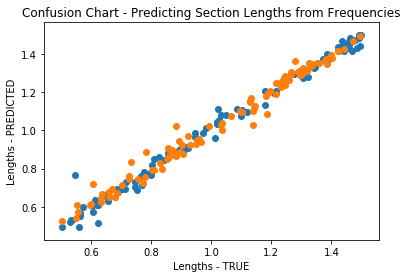

<function matplotlib.pyplot.show(*args, **kw)>

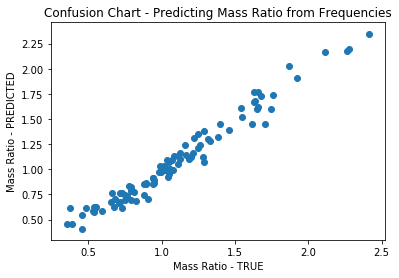

In [56]:
#Plot results TRUE vs PREDICTED - best would be a straight diagonal line at TRUE=PREDICTED

plt.xlabel('Lengths - TRUE')
plt.ylabel('Lengths - PREDICTED')
plt.title('Confusion Chart - Predicting Section Lengths from Frequencies');
plt.scatter(Y_test[:,0], Y_test_pred_unscaled[:,0])
plt.scatter(Y_test[:,1], Y_test_pred_unscaled[:,1])
plt.show()

plt.scatter(Y_test[:,2], Y_test_pred_unscaled[:,2])
plt.xlabel('Mass Ratio - TRUE')
plt.ylabel('Mass Ratio - PREDICTED')

plt.title('Confusion Chart - Predicting Mass Ratio from Frequencies');
plt.show

In [36]:
num =1000

dataset3_X = np.empty(shape=(num,500)) #frequencies for sections 1 (0,99) and sections 2 (100,199)
dataset3_Y = np.empty(shape=(num,10)) #weight1,weight2,length1,length2

In [39]:
##QUINT PENDULUM
#this is a bit slow - If you have a crummy computer skip this cell and load dataset1_Y.csv and dataset1_X.csv below instead 

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)

#linear-ish "mustache"
start = 83
initial_positions=[start,start,start,start,start] # starting angle of each section of pendulum
#masses=[5,2.5] we're going to vary this
#lengths=[1,10] we're going to vary this

for i in range(0,num):
    dataset3_Y[i] = np.random.uniform(low=0.5,high=1.5,size=10)
    p = integrate_pendulum(n=5, times=t,initial_positions=initial_positions,masses=dataset3_Y[i,0:5],lengths=dataset3_Y[i,5:10])
    x_pos, y_pos = get_xy_coords(p)
    yr1 = fft(y_pos[0:bins,1]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][0:100] = 2/bins * np.abs(yr1[0:np.int(bins/2)]) # positive freqs only
    yr2 = fft(y_pos[0:bins,2]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][100:200] = 2/bins * np.abs(yr2[0:np.int(bins/2)]) # positive freqs only
    yr3 = fft(y_pos[0:bins,3]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][200:300] = 2/bins * np.abs(yr3[0:np.int(bins/2)]) # positive freqs only
    yr4 = fft(y_pos[0:bins,4]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][300:400] = 2/bins * np.abs(yr4[0:np.int(bins/2)]) # positive freqs only
    yr5 = fft(y_pos[0:bins,5]) # "raw" FFT with both + and - frequencies
    dataset3_X[i][400:500] = 2/bins * np.abs(yr5[0:np.int(bins/2)]) # positive freqs only
    
    

### DISCUSSION
~0.31 Mean Square Error (MSE) is not good at all, how can we improve on this?

Both pendulum sections are included, maybe only one will be better??

In [652]:
mse_sec1 = {} 
for name, clf in zip(names, regressors):
        print("training ",name)
        clf.fit(X_train_scaled_nl[:,0:100], Y_train_scaled_nl)
        mse_sec1[name] = mean_squared_error(Y_test_scaled_nl, clf.predict(X_test_scaled_nl[:,0:100]))
mse_sec2 = {} 
for name, clf in zip(names, regressors):
        print("training ",name)
        clf.fit(X_train_scaled_nl[:,100:200], Y_train_scaled_nl)
        mse_sec2[name] = mean_squared_error(Y_test_scaled_nl, clf.predict(X_test_scaled_nl[:,100:200]))

training  LinearRegression
training  KNeighborsRegressor
training  DecisionTreeRegressor
training  MultiTaskLasso
training  MultiTaskElasticNet
training  Ridge
training  MLPRegressor
training  MultiOutputRegressor(SVR())
training  MultiOutputRegressor(XGBRegressor())
training  LinearRegression
training  KNeighborsRegressor
training  DecisionTreeRegressor
training  MultiTaskLasso
training  MultiTaskElasticNet
training  Ridge
training  MLPRegressor
training  MultiOutputRegressor(SVR())
training  MultiOutputRegressor(XGBRegressor())


In [653]:
sorted(mse_sec1.items(), key=lambda kv: kv[1])

[('MultiOutputRegressor(XGBRegressor())', 0.4233992962749124),
 ('MultiTaskElasticNet', 0.42607363009715926),
 ('MultiOutputRegressor(SVR())', 0.42667854540341077),
 ('MultiTaskLasso', 0.44727210418422825),
 ('MLPRegressor', 0.5265087015303128),
 ('KNeighborsRegressor', 0.5340749631802022),
 ('Ridge', 0.5920845690635013),
 ('LinearRegression', 0.6455380198756933),
 ('DecisionTreeRegressor', 0.850005884320915)]

In [654]:
sorted(mse_sec2.items(), key=lambda kv: kv[1])

[('MultiOutputRegressor(XGBRegressor())', 0.4417368852293927),
 ('Ridge', 0.46478703751351025),
 ('LinearRegression', 0.46978194262002937),
 ('MultiOutputRegressor(SVR())', 0.49749122081464237),
 ('MultiTaskElasticNet', 0.5005242969662883),
 ('MultiTaskLasso', 0.5404546067591092),
 ('MLPRegressor', 0.546979976213745),
 ('KNeighborsRegressor', 0.5897468966851619),
 ('DecisionTreeRegressor', 0.9489394254805201)]

In [73]:
X_train.shape

(900, 200)

In [78]:
###VERY IMPORTANT - we have to de-scale to compare with the original data

Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)

### Discussion
~0.017 MSE or ~98.3% correct is MUCH better

Just for curiosity let's re-run the two seperate sections - if one is much better then the other perhaps we can have a smaller (faster) model

In [672]:
mse_sec1e = {} 
for name, clf in zip(names, regressors):
        print("training ",name)
        clf.fit(X_train_scaled_nl[:,0:100], Y_train_scaled_nl)
        mse_sec1e[name] = mean_squared_error(Y_test_scaled_nl, clf.predict(X_test_scaled_nl[:,0:100]))
mse_sec2e = {} 
for name, clf in zip(names, regressors):
        print("training ",name)
        clf.fit(X_train_scaled_nl[:,100:200], Y_train_scaled_nl)
        mse_sec2e[name] = mean_squared_error(Y_test_scaled_nl, clf.predict(X_test_scaled_nl[:,100:200]))

training  LinearRegression
training  KNeighborsRegressor
training  DecisionTreeRegressor
training  MultiTaskLasso
training  MultiTaskElasticNet
training  Ridge
training  MLPRegressor
training  MultiOutputRegressor(SVR())
training  MultiOutputRegressor(XGBRegressor())
training  LinearRegression
training  KNeighborsRegressor
training  DecisionTreeRegressor
training  MultiTaskLasso
training  MultiTaskElasticNet
training  Ridge
training  MLPRegressor
training  MultiOutputRegressor(SVR())
training  MultiOutputRegressor(XGBRegressor())


In [674]:
print("models based on section1", sorted(mse_sec1e.items(), key=lambda kv: kv[1]))
print("models based on section2",sorted(mse_sec2e.items(), key=lambda kv: kv[1]))

models based on section1 [('MultiOutputRegressor(SVR())', 0.07026073763765174), ('MLPRegressor', 0.07051841606613216), ('MultiOutputRegressor(XGBRegressor())', 0.09098480360144663), ('MultiTaskElasticNet', 0.16416759316547677), ('MultiTaskLasso', 0.1905766569628685), ('Ridge', 0.20060736492115447), ('LinearRegression', 0.21126982133111494), ('KNeighborsRegressor', 0.22515320843607248), ('DecisionTreeRegressor', 0.3756777812754258)]
models based on section2 [('MLPRegressor', 0.08083369873864794), ('MultiOutputRegressor(SVR())', 0.10967355139547279), ('MultiOutputRegressor(XGBRegressor())', 0.14249589127258191), ('Ridge', 0.1780282477459776), ('LinearRegression', 0.18143320067060353), ('MultiTaskElasticNet', 0.2487132179895578), ('DecisionTreeRegressor', 0.25334780421584796), ('KNeighborsRegressor', 0.2684149104665829), ('MultiTaskLasso', 0.30124667001287525)]


### Both Sections 1 and 2 seem Necesary to get a good model

this is typical - most machine learning non-linear regression problems require ALL inputs and as much data as possible.  <b> feature reduction that we see in classification or in easier low dimension regression problems just doesn't seem to be possible with harder problems. 
    
We didn't actually save the best model - lets re-create the model so we can evaluate preformance

In [75]:
mymodel = MLPRegressor(hidden_layer_sizes=(100,400,100,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=2000,
                                       learning_rate_init=0.01,
                                       alpha=0.1)
mymodel.fit(X_train_scaled_nl, Y_train_scaled_nl)

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 400, 100), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [76]:
mean_squared_error(Y_test_scaled_nl, mymodel.predict(X_test_scaled_nl))

0.022702091630336717

In [77]:
Y_test_pred_scaled = mymodel.predict(X_test_scaled_nl)

In [78]:
###VERY IMPORTANT - we have to de-scale to compare with the original data

Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)

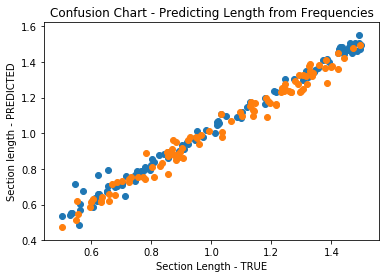

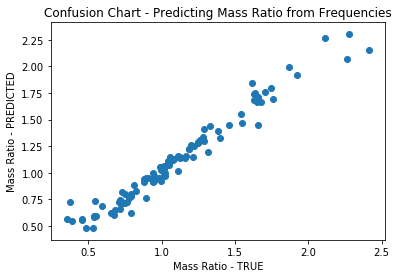

In [79]:
plt.scatter(Y_test[:,0], Y_test_pred_unscaled[:,0])
plt.xlabel('Section Length - TRUE')
plt.ylabel('Section length - PREDICTED')

plt.title('Confusion Chart - Predicting Length from Frequencies');

plt.scatter(Y_test[:,1], Y_test_pred_unscaled[:,1])
plt.show()

plt.xlabel('Mass Ratio - TRUE')
plt.ylabel('Mass Ratio - PREDICTED')
plt.title('Confusion Chart - Predicting Mass Ratio from Frequencies');
plt.scatter(Y_test[:,2], Y_test_pred_unscaled[:,2])

### Discussion

<b>Confusion Chart</b> of true vs predicted looks very good - basically a diagonal line.

Mass Ratio Confusion Chart shows few data points at higher ratios.  This is an artifact of our data generation.  We'll fix thi sin our next experiment 

## Create a Double Pendulum Non-linear Dataset for Machine Learning

### Now lets do a harder non-linear problem by setting starting positions  at  (92,92) 

#### At angles of 95+ the pendulum sections are traveling so fast we would have to simulate with more time steps

X will be the resulting fundemental frequencies from Double Pendulum section 1 and 2

Y will be varying mass ration from (0.5,1.5) (fixing ratio sampling problem) and lengths from (0.5,1.5) 

Can we predict <b> Y (the mass and length of each pendulum section) </b>from <b> X (the fundamental frequencies of each section of the double pendulum)? </b>


In [727]:
num =1000

dataset2_X = np.empty(shape=(num,200)) #frequencies for sections 1 (0,99) and sections 2 (100,199)
dataset2_Y = np.empty(shape=(num,3)) #length1,length2,mass ratio w1/w2

In [728]:
#this is a bit slow - If you have a crummy computer skip this cell and load dataset1_Y.csv and dataset1_X.csv below instead 

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)

#linear-ish "mustache"
initial_positions=[92,92] # starting angle of each section of pendulum
#masses=[5,2.5] we're going to vary this
#lengths=[1,10] we're going to vary this

for i in range(0,num):
    dataset2_Y[i][0] = np.random.uniform(low=0.5,high=1.5,size=1)
    dataset2_Y[i][1] = np.random.uniform(low=0.5,high=1.5,size=1)
    dataset2_Y[i][2] = np.random.uniform(low=0.5,high=1.5,size=1)
    p = integrate_pendulum(n=2, times=t,initial_positions=initial_positions,masses=[dataset2_Y[i,2],1],lengths=dataset2_Y[i,0:2])
    x_pos, y_pos = get_xy_coords(p)
    yr1 = fft(y_pos[0:bins,1]) # "raw" FFT with both + and - frequencies
    dataset2_X[i][0:100] = 2/bins * np.abs(yr1[0:np.int(bins/2)]) # positive freqs only
    yr2 = fft(y_pos[0:bins,2]) # "raw" FFT with both + and - frequencies
    dataset2_X[i][100:200] = 2/bins * np.abs(yr2[0:np.int(bins/2)]) # positive freqs only
    

In [4]:
#save dataset for anyone who doesn't want to regen data or has a potato computer and can't
np.savetxt("dataset2_X.csv",dataset2_X,delimiter=',')
np.savetxt("dataset2_Y.csv",dataset2_Y,delimiter=',')

NameError: name 'dataset2_X' is not defined

In [5]:
#load saved dataset rather than generating your own
dataset2_X = np.loadtxt("dataset2_X.csv",delimiter=',')
dataset2_Y = np.loadtxt("dataset2_Y.csv",delimiter=',')

In [6]:
print("generated X frequency bins with shape =",dataset2_X.shape)
print("generated Y (w1,w2,ratio_m1_over_m2) with shape =",dataset2_Y.shape)


generated X frequency bins with shape = (1000, 200)
generated Y (w1,w2,ratio_m1_over_m2) with shape = (1000, 3)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset2_X, dataset2_Y, test_size=0.10, random_state=42)

In [8]:
X_train.shape

(900, 200)

In [9]:
x_scaler_nl = StandardScaler()
X_train_scaled_nl = x_scaler_nl.fit_transform(X_train)
X_test_scaled_nl = x_scaler_nl.transform(X_test)

y_scaler_nl = StandardScaler().fit(Y_train)
Y_train_scaled_nl = y_scaler_nl.transform(Y_train)
Y_test_scaled_nl = y_scaler_nl.transform(Y_test)

In [65]:
mse_nl = {} 
for name, clf in zip(names, regressors):
        print("training ",name)
        clf.fit(X_train_scaled_nl, Y_train_scaled_nl)
        mse_nl[name] = mean_squared_error(Y_test_scaled_nl, clf.predict(X_test_scaled_nl))

training  LinearRegression
training  KNeighborsRegressor
training  DecisionTreeRegressor
training  MultiTaskLasso
training  MultiTaskElasticNet
training  Ridge
training  MLPRegressor
training  MultiOutputRegressor(SVR())
training  MultiOutputRegressor(XGBRegressor())


In [66]:
sorted(mse_nl.items(), key=lambda kv: kv[1])

[('MLPRegressor', 0.1604594193389962),
 ('MultiOutputRegressor(SVR())', 0.23225549805595755),
 ('MultiOutputRegressor(XGBRegressor())', 0.2476207908026283),
 ('MultiTaskElasticNet', 0.2917700123257431),
 ('Ridge', 0.32595866962757386),
 ('LinearRegression', 0.32644333291688393),
 ('MultiTaskLasso', 0.3526248875831897),
 ('KNeighborsRegressor', 0.4925504398618222),
 ('DecisionTreeRegressor', 0.8434699946488414)]

In [10]:
mymodel = MLPRegressor(hidden_layer_sizes=(100,400,100,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=2000,
                                       learning_rate_init=0.01,
                                       alpha=0.1)
mymodel.fit(X_train_scaled_nl, Y_train_scaled_nl)

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 400, 100), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [11]:
Y_test_pred_scaled = mymodel.predict(X_test_scaled_nl)

In [12]:
###VERY IMPORTANT - we have to de-scale to compare with the original data

Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)
mean_squared_error(Y_test,Y_test_pred_unscaled)

0.012261379110768399

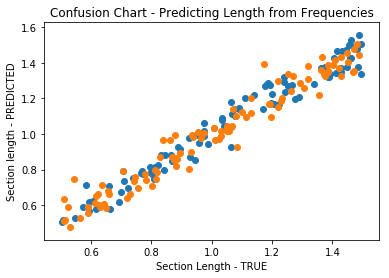

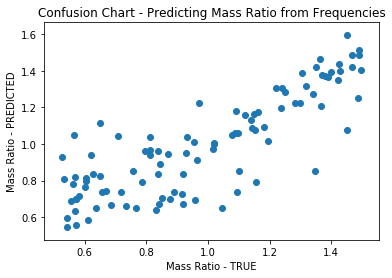

In [13]:
plt.scatter(Y_test[:,0], Y_test_pred_unscaled[:,0])
plt.xlabel('Section Length - TRUE')
plt.ylabel('Section length - PREDICTED')

plt.title('Confusion Chart - Predicting Length from Frequencies');

plt.scatter(Y_test[:,1], Y_test_pred_unscaled[:,1])
plt.show()

plt.xlabel('Mass Ratio - TRUE')
plt.ylabel('Mass Ratio - PREDICTED')
plt.title('Confusion Chart - Predicting Mass Ratio from Frequencies');
plt.scatter(Y_test[:,2], Y_test_pred_unscaled[:,2])

### The MLP model is still not very good (~85% correct)

Let's check the accuracy of training (as opposed to test data)

If accuracy of training data is very good we are <b>overfitting</b>

In [15]:
#This is overfitting

Y_train_pred_scaled = mymodel.predict(X_train_scaled_nl)
Y_train_pred_unscaled = y_scaler_nl.inverse_transform(Y_train_pred_scaled)
mean_squared_error(Y_train,Y_train_pred_unscaled)


0.0010985014583712771

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [[500+100*i,700,500] for i in range(2,4) ],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['adaptive'],
              'learning_rate_init': [0.01,0.001], 
              #'power_t': [0.5],
              'alpha': [4.0,8.0,16.0],
              'max_iter': [2000]
              
             # 'early_stopping': [True],
             # 'warm_start': [False]
             }
_GS = GridSearchCV(mlp, param_grid=param_grid,  scoring = 'neg_mean_squared_error',
                   cv=3, verbose=True, pre_dispatch='2*n_jobs',n_jobs=-1)
_GS.fit(X_train_scaled_nl, Y_train_scaled_nl)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  36 | elapsed:  3.4min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.7min finished
C:\Users\rditlas8\AppData\Local\Continuum\anaconda3\envs\vrsense1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [[700, 700, 500], [800, 700, 500]], 'activation': ['relu'], 'solver': ['adam'], 'learning_rate': ['adaptive'], 'learning_rate_init': [0.01, 0.001], 'alpha': [4.0, 8.0, 16.0], 'max_iter': [2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)

In [94]:
_GS.best_estimator_

MLPRegressor(activation='relu', alpha=4.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[700, 700, 500], learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [95]:
mean_squared_error(Y_test_scaled_nl, _GS.best_estimator_.predict(X_test_scaled_nl))

0.1460808034918916

In [96]:
#This is overfitting
mean_squared_error(Y_train_scaled_nl, _GS.best_estimator_.predict(X_train_scaled_nl))

0.02024285011228937